## Load packages

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import sklearn.metrics

import scipy.linalg
import scipy.spatial.distance
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('ytick', labelsize=7)
import seaborn as sns
import os
import psutil
import polars as pl

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

import datetime

def make_jointplot(embedding, colouring, cmpd, save_path=None):
    
    # Generate a color palette based on unique values in the colouring column
    unique_treatments = embedding[colouring].unique()
    palette = sns.color_palette("husl", len(unique_treatments))
    color_map = dict(zip(unique_treatments, palette))
    
    # Adjust colors and transparency if colouring is 'Metadat_cmpdName'
    if colouring == 'Metadata_cmpdName':
        if 'DMSO' in color_map:
            color_map['DMSO'] = 'black'
    
    embedding['color'] = embedding[colouring].map(color_map)
    point_size = 20
    embedding['size'] = point_size
    
    # Increase the DPI for displaying
    plt.rcParams['figure.dpi'] = 300
    
    # Create the base joint plot
    g = sns.JointGrid(x='UMAP1', y='UMAP2', data=embedding, height=10)

    # Plot KDE plots for each category
    for treatment in unique_treatments:
        subset = embedding[embedding[colouring] == treatment]
        
        sns.kdeplot(x=subset["UMAP1"], ax=g.ax_marg_x, fill=True, color=color_map[treatment], legend=False)
        sns.kdeplot(y=subset["UMAP2"], ax=g.ax_marg_y, fill=True, color=color_map[treatment], legend=False)

    # Plot the scatter plots
    for treatment in unique_treatments:
        subset = embedding[embedding[colouring] == treatment]
        alpha_val = 0.3 if treatment == 'DMSO' and colouring == 'Metadat_cmpdName' else 0.5
        g.ax_joint.scatter(subset["UMAP1"], subset["UMAP2"], c=subset['color'], s=subset['size'], label=treatment, alpha=alpha_val, edgecolor='white', linewidth=0.5)
    
    g.ax_joint.set_title(cmpd)
    g.ax_joint.legend()

    # Display the plot
    

    
    if save_path != None:
        current_time = datetime.datetime.now()
        timestamp = current_time.strftime("%Y%m%d_%H%M%S")
        g.savefig(f"{save_path}.png", dpi=300)

    plt.show()
    
    
import time
def subsample_dataset_pl(df, grouping_cols, fraction=0.5):
    '''
    Subsample a dataset while preserving the distribution of plates and Metadata_cmpdName using Polars.

    Parameters:
    - df: The original Polars DataFrame.
    - plate_column: The column name representing the plates.
    - cmpd_column: The column name representing the Metadata_cmpdName.
    - fraction: The fraction of data to keep for each group. Default is 0.5 (50%).

    Returns:
    - A subsampled Polars DataFrame.
    '''

    # Start tracking time
    start_time = time.time()

    # Initialize an empty list to store subsampled data from each group
    subsampled_data = []

    # Group by plates and Metadata_cmpdName
    grouped = df.groupby(grouping_cols)

    # For each group, subsample and append to the subsampled_data list, with progress bar
    for name, group in tqdm(grouped, desc="Subsampling groups", unit="group"):
        group_size = group.height
        subsample_size = int(group_size * fraction)
        subsampled_group = group.sample(n=subsample_size, seed=42)
        subsampled_data.append(subsampled_group)

    # Concatenate all subsampled groups together
    subsampled_df = pl.concat(subsampled_data)

    # Print running time
    end_time = time.time()
    print(f"Finished in {end_time - start_time:.2f} seconds.")

    return subsampled_df


## Load data

In [10]:
mad_norm_df = pl.read_parquet('sc_profiles_normalized.parquet')
mad_norm_df = mad_norm_df.filter(pl.col('Metadata_Plate') != "P101384")
features_fixed = [f for f in mad_norm_df.columns if "Feature" in f]

In [11]:
subsample_data = subsample_dataset_pl(mad_norm_df, ["Metadata_Plate", "Metadata_cmpdNameConc", "Metadata_Well"], 0.05)

/tmp/ipykernel_192692/1370106096.py:78: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  grouped = df.groupby(grouping_cols)
Subsampling groups: 1657group [00:03, 424.96group/s]


Finished in 5.46 seconds.


## Build Autoencoder

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_autoencoder(input_dim, encoding_dim):
    # Input Layer
    input_layer = layers.Input(shape=(input_dim,))

    # Encoder Layers
    encoded = layers.Dense(100, activation='relu')(input_layer)
    encoded = layers.Dense(50, activation='relu')(encoded)
    encoded = layers.Dense(encoding_dim, activation='relu')(encoded)

    # Decoder Layers
    decoded = layers.Dense(50, activation='relu')(encoded)
    decoded = layers.Dense(100, activation='relu')(decoded)
    decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)

    # Autoencoder Model
    autoencoder = models.Model(input_layer, decoded)

    # Encoder Model
    encoder = models.Model(input_layer, encoded)
    return autoencoder, encoder


## Create parametric umap model

In [15]:
import umap
import umap.parametric_umap

def run_param_umap(df, features):
# Assuming 'data' is your dataset
    feature_data = df.select(features).to_pandas()
    meta_features = [col for col in df.columns if col not in features]
    meta_data = df.select(meta_features)

    # Run autoencoder
    input_dim = feature_data.shape[1]
    autoencoder, encoder = build_autoencoder(input_dim=input_dim, encoding_dim=2)

    parametric_model = umap.parametric_umap.ParametricUMAP(
        encoder=encoder,
        dims=(input_dim,),
        n_components=2,
        n_epochs=50
    )
    embedding = parametric_model.fit_transform(feature_data)

    #Prepare output
    umap_df = pl.DataFrame(embedding)

    old_column_name = umap_df.columns[0]
    old_column_name2 = umap_df.columns[1]
    new_column_name = "UMAP1"
    new_column_name2 = "UMAP2"
    umap_df = umap_df.rename({old_column_name: new_column_name, old_column_name2: new_column_name2})

    merged_df = pl.concat([meta_data, umap_df], how="horizontal")
    make_jointplot(merged_df.to_pandas(), "Metadata_cmpdName", cmpd ="", save_path= "Figures/AE_UMAP_10ep")


    parametric_model._history.keys()
    fig, axs = plt.subplots(ncols=2, figsize=(10,5))
    ax = axs[0]
    ax.plot(embedder._history['loss'])
    ax.set_ylabel('Cross Entropy')
    ax.set_xlabel('Epoch')

    ax = axs[1]
    ax.plot(embedder._history['reconstruction_loss'], label='train')
    ax.plot(embedder._history['val_reconstruction_loss'], label='valid')
    ax.legend()
    ax.set_ylabel('Cross Entropy')
    ax.set_xlabel('Epoch')
    
    return merged_df

In [16]:
run_param_umap(subsample_data, features_fixed)

Epoch 1/10


2023-11-24 18:19:02.112639: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fb5482c6d20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-24 18:19:02.112665: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2023-11-24 18:19:02.128612: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-24 18:19:02.166523: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1700846342.294604  193703 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4148/4148 [==============================] - 33s 7ms/step - loss: 0.2514
Epoch 2/10
4148/4148 [==============================] - 27s 6ms/step - loss: 0.2426
Epoch 3/10
4148/4148 [==============================] - 27s 7ms/step - loss: 0.2408
Epoch 4/10
4148/4148 [==============================] - 28s 7ms/step - loss: 0.2396
Epoch 5/10
4148/4148 [==============================] - 27s 7ms/step - loss: 0.2389
Epoch 6/10
4148/4148 [==============================] - 27s 7ms/step - loss: 0.2385
Epoch 7/10
4148/4148 [==============================] - 27s 7ms/step - loss: 0.2380
Epoch 8/10
4148/4148 [==============================] - 27s 7ms/step - loss: 0.2378
Epoch 9/10
4148/4148 [==============================] - 28s 7ms/step - loss: 0.2375
Epoch 10/10
4148/4148 [==============================] - 27s 7ms/step - loss: 0.2373


Metadata_Plate,Metadata_Well,Metadata_Site,Metadata_cmpdName,compound_name,moa,Metadata_cmpdConc,Metadata_cmpdNameConc,UMAP1,UMAP2
str,str,str,str,str,str,f64,str,f32,f32
"""P101338""","""E12""","""s2""","""[SORB]""","""Sorbitol""",null,20.0,"""[SORB] 20.0""",0.0,12.513178
"""P101338""","""E12""","""s4""","""[SORB]""","""Sorbitol""",null,20.0,"""[SORB] 20.0""",2.311881,5.882345
"""P101338""","""E12""","""s3""","""[SORB]""","""Sorbitol""",null,20.0,"""[SORB] 20.0""",0.0,14.598182
"""P101338""","""E12""","""s7""","""[SORB]""","""Sorbitol""",null,20.0,"""[SORB] 20.0""",0.0,15.388435
"""P101338""","""E12""","""s6""","""[SORB]""","""Sorbitol""",null,20.0,"""[SORB] 20.0""",4.66081,0.0
"""P101338""","""E12""","""s2""","""[SORB]""","""Sorbitol""",null,20.0,"""[SORB] 20.0""",1.42489,1.930963
"""P101338""","""E12""","""s4""","""[SORB]""","""Sorbitol""",null,20.0,"""[SORB] 20.0""",3.395458,5.743177
"""P101338""","""E12""","""s5""","""[SORB]""","""Sorbitol""",null,20.0,"""[SORB] 20.0""",2.712973,1.073258
"""P101338""","""E12""","""s1""","""[SORB]""","""Sorbitol""",null,20.0,"""[SORB] 20.0""",0.0,14.686228


In [17]:
umap_df = _

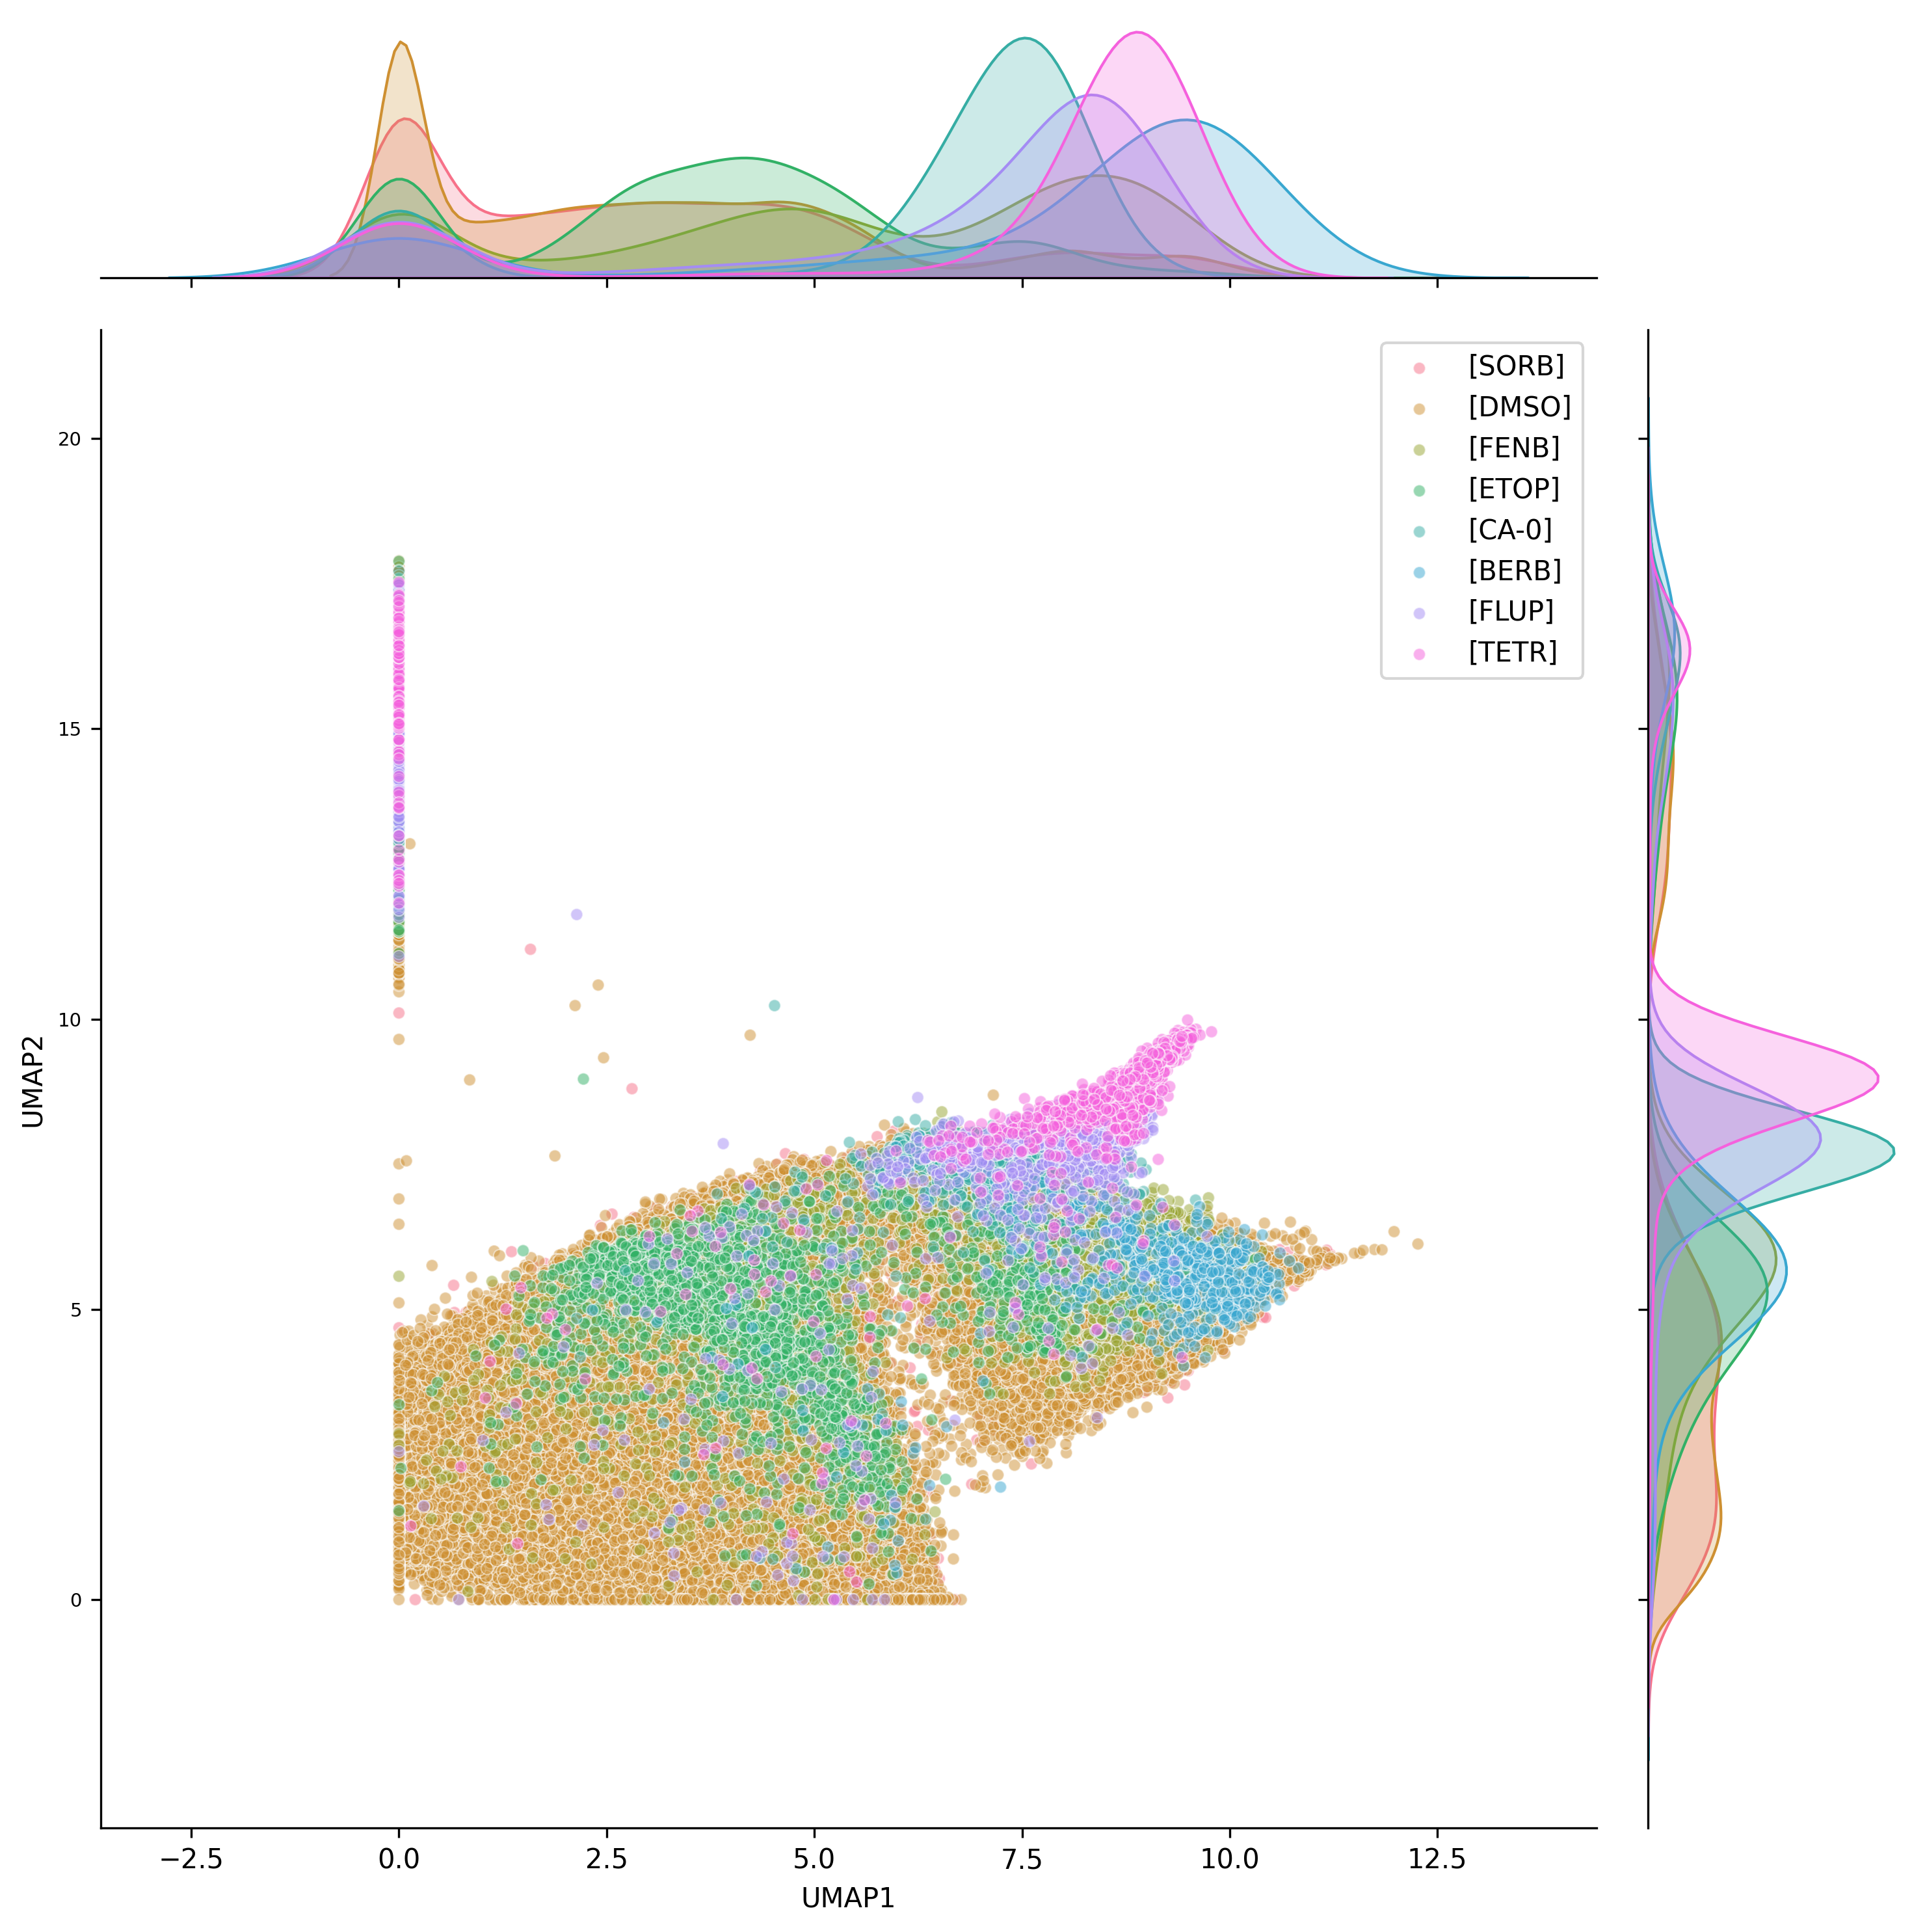

In [23]:
make_jointplot(umap_df.to_pandas(), "Metadata_cmpdName", cmpd ="", save_path= "Figures/AE_UMAP_10ep")

In [3]:
embedder = ParametricUMAP(n_epochs = 50, verbose=True)

In [4]:
embedding = embedder.fit_transform(train_images)

ParametricUMAP(optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7ff6a3816700>)
Construct fuzzy simplicial set
Fri Apr 16 13:15:28 2021 Finding Nearest Neighbors
Fri Apr 16 13:15:28 2021 Building RP forest with 17 trees
Fri Apr 16 13:15:30 2021 parallel NN descent for 16 iterations
	 0  /  16
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
Fri Apr 16 13:15:39 2021 Finished Nearest Neighbor Search
Fri Apr 16 13:15:42 2021 Construct embedding
Epoch 1/10
1905/1905 [==============================] - 15s 8ms/step - loss: 0.2224
Epoch 2/10
1905/1905 [==============================] - 14s 7ms/step - loss: 0.1372
Epoch 3/10
1905/1905 [==============================] - 14s 7ms/step - loss: 0.1230
Epoch 4/10
1905/1905 [==============================] - 14s 7ms/step - loss: 0.1141
Epoch 5/10
1905/1905 [==============================] - 14s 7ms/step - loss: 0.1102
Epoch 6/10
1905/1905 [==============================] - 14s 8ms/step - loss: 0.1076
Epoch 7/10
1905/1905 [=============

### plot results

In [5]:
import matplotlib.pyplot as plt

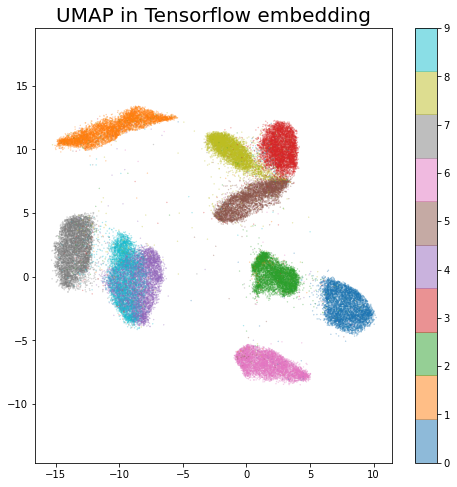

In [6]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=Y_train.astype(int),
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### plotting loss

In [7]:
embedder._history.keys()

dict_keys(['loss'])

Text(0.5, 0, 'Epoch')

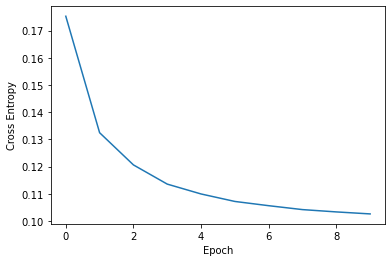

In [8]:
fig, ax = plt.subplots()
ax.plot(embedder._history['loss'])
ax.set_ylabel('Cross Entropy')
ax.set_xlabel('Epoch')

### train the model for longer

In [9]:
embedder = ParametricUMAP(n_epochs = 200, verbose=True)

embedding = embedder.fit_transform(train_images)

ParametricUMAP(optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7ff5f46ca0d0>)
Construct fuzzy simplicial set
Fri Apr 16 13:18:21 2021 Finding Nearest Neighbors
Fri Apr 16 13:18:21 2021 Building RP forest with 17 trees
Fri Apr 16 13:18:22 2021 parallel NN descent for 16 iterations
	 0  /  16
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
Fri Apr 16 13:18:24 2021 Finished Nearest Neighbor Search
Fri Apr 16 13:18:24 2021 Construct embedding
Epoch 1/10
7798/7798 [==============================] - 59s 7ms/step - loss: 0.1660
Epoch 2/10
7798/7798 [==============================] - 58s 7ms/step - loss: 0.1082
Epoch 3/10
7798/7798 [==============================] - 59s 8ms/step - loss: 0.1021
Epoch 4/10
7798/7798 [==============================] - 58s 7ms/step - loss: 0.0999
Epoch 5/10
7798/7798 [==============================] - 58s 7ms/step - loss: 0.0986
Epoch 6/10
7798/7798 [==============================] - 58s 7ms/step - loss: 0.0977
Epoch 7/10
7798/7798 [=============

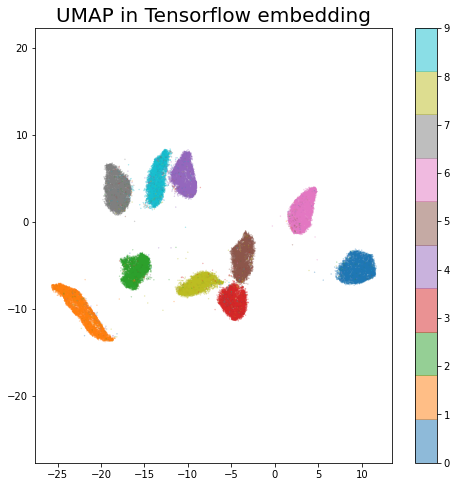

In [13]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=Y_train.astype(int),
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### saving and loading

In [10]:
from umap.parametric_umap import load_ParametricUMAP

In [11]:
embedder.save('/tmp/model')

INFO:tensorflow:Assets written to: /tmp/model/encoder/assets
Keras encoder model saved to /tmp/model/encoder
INFO:tensorflow:Assets written to: /tmp/model/parametric_model/assets
Keras full model saved to /tmp/model/parametric_model
Pickle of ParametricUMAP model saved to /tmp/model/model.pkl


In [12]:
embedder = load_ParametricUMAP('/tmp/model')

Pickle of ParametricUMAP model loaded from /tmp/model/model.pkl
Keras encoder model loaded from /tmp/model/encoder
Keras full model loaded from /tmp/model/parametric_model
